In [337]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import combinations

In [341]:
COLOR = '#134f5c'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
plt.rcParams['figure.facecolor'] = "#fdfdf8"

## 1) Genetic Drift

In [408]:
class GeneticDriftModel:
    """
    Genetic drift model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a genetic drift model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, t, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.nb_simulations = nb_simulations

    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        """
        # Initialize population at time t=0
        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N)
        nb_B = self.N - nb_A
        population = np.concatenate((np.full(nb_A, 'A'), np.full(nb_B, 'B')))
        allele_ids = np.arange(self.N)

        # Initialize allele frequencies, that will evolve through generations
        current_A_freq = self.p

        # Store all values of allele frequencies
        A_freq = [current_A_freq]

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        parents_matrix = np.random.randint(self.N, size=(self.t, self.N))

        for generation in range(self.t):
            # Retrieve parents
            parents = parents_matrix[generation]

            # Generate gen t + 1
            population = population[parents]

            current_A_freq = np.sum(population=='A') / self.N
            A_freq.append(current_A_freq)

        return A_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated with empirical mean over all simulations
            
        Returns
        -------
        avg_A_freq : list of proba
            For each generation, average allele A frequency over all simulations
        freq_A_fixed : proba
            Frequency of allele A being fixed
        avg_time_A_fixed : proba
            Average allele A fixation time (in number of generations)
        """

        all_A_freq = []
        for simulation in range(self.nb_simulations):
            A_freq = self.simulation()
            all_A_freq.append(A_freq)

        # 1. Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        
        # 2. Compute frequency of fixed simulations
        # Get all simulations where A is fixed (ie. a frequency equals 1 or 0)
        sims_fixed_A_freq = [A_freq for A_freq in all_A_freq if (1 in A_freq) or (0 in A_freq)]

        if not sims_fixed_A_freq:
            error_message = "No simulations got fixed. Consider increasing t, or changing p"
            raise RuntimeError(error_message)

        # Compute frequencies of fixed simulations
        freq_A_fixed = len(sims_fixed_A_freq) / self.nb_simulations

        # 3. Compute average fixation time
        # Look for first generation where allele frequency is 1 or 0 within all fixed simulations
        time_A_fixed = [A_freq.index(1) if 1 in A_freq else A_freq.index(0) for A_freq in sims_fixed_A_freq]
        avg_time_A_fixed = np.mean(time_A_fixed)

        return avg_A_freq, freq_A_fixed, avg_time_A_fixed
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_t(self, new_t):
        self.t = new_t

### a) Allele frequency over time

To estimate the allele frequency over time, several simulations are run, and allele frequency is estimated with the empirical mean of allele frequency over all simulations

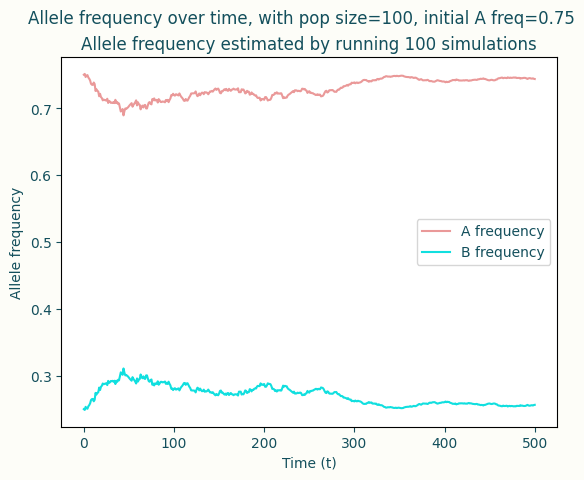

In [382]:
model = GeneticDriftModel(N=100, t=500, p=0.75, nb_simulations=100)

avg_A_freq, _, _ = model.estimate_simulation_parameters()
avg_B_freq = 1 - avg_A_freq
plt.plot(avg_A_freq, label="A frequency", color="#ea9999")
plt.plot(avg_B_freq, label="B frequency", color="#11dfdf")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Allele frequency")
plt.suptitle(f"Allele frequency over time, with pop size={model.N}, initial A freq={model.p}")
plt.title(f"Allele frequency estimated by running {model.nb_simulations} simulations");

### Comparison with theorical results

We notice that expected allele frequency remains constant over time. This is not contradictory with the fact that allele frequency will at a moment, be 1 or 0. On the graphe above we see that allele A frequency remains constant at 0.7: this means that in 70% of simulations, allele A frequency will be 1, whereas it will be 0 in 30% of simulations.

If we look at several individual allele frequencies (not estimated from several simulations), we notice that is always fixed to 1 or 0:

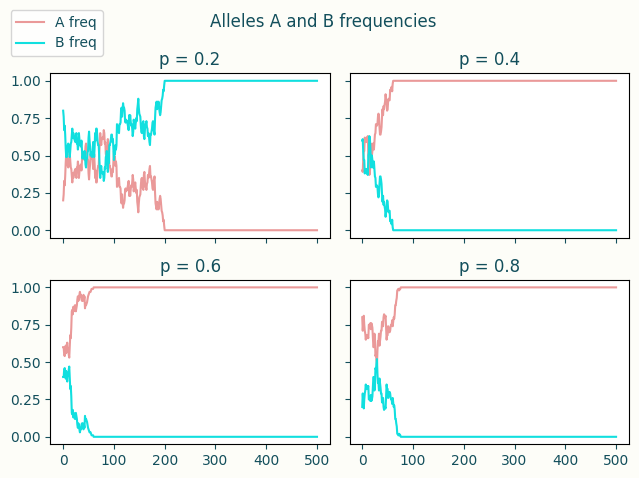

In [357]:
f, axes = plt.subplots(2, 2, sharey=True, sharex=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
for p, sp in zip([0.2, 0.4, 0.6, 0.8], [sp1, sp2, sp3, sp4]):
    model.update_p(p)
    A_freq = model.simulation()
    B_freq = 1 - np.array(A_freq)
    sp.plot(A_freq, label="A freq", color="#ea9999")
    sp.plot(B_freq, label="B freq", color="#11dfdf")
    sp.set_title(f"p = {model.p}")
f.legend(["A freq", "B freq"], loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
f.suptitle("Alleles A and B frequencies")
f.tight_layout()

### b) Fixation probability of A depending on p

To estimate fixation probability, several simulations are run for 10 values of p : 0, 0.1, 0.2, ..., 0.9, 1. Then, the fixation probability is estimated with the frequency of allele A being fixed in all simulations run for the given value of p.

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


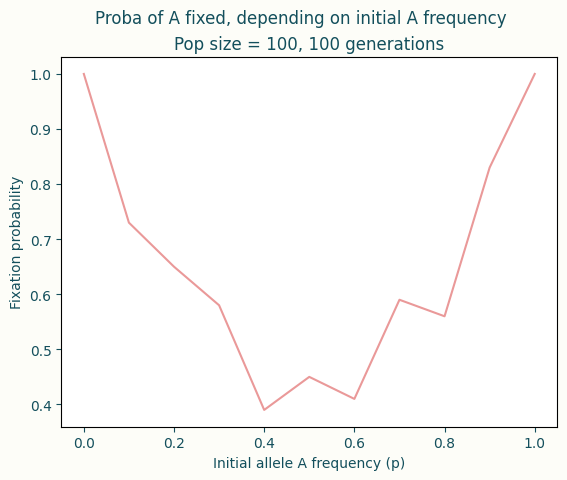

In [358]:
all_proba_A_fixed = []
all_proba_B_fixed = []
p_values = np.round(np.linspace(0, 1, 11), 1)
model.update_t(100)
for p in tqdm(p_values):
    model.update_p(p)
    _, freq_A_fixed, _ = model.estimate_simulation_parameters()
    all_proba_A_fixed.append(freq_A_fixed)
    
plt.plot(p_values, all_proba_A_fixed, label="Proba A fixed", color="#ea9999")
plt.xlabel("Initial allele A frequency (p)")
plt.ylabel("Fixation probability")
plt.suptitle("Proba of A fixed, depending on initial A frequency");
plt.title(f"Pop size = {model.N}, {model.t} generations");

### Comparison with theorical results

We notice that if the original allele A frequency is above 0.5, the fixation probability is equal to the frequency of A in gen t=0. If the frequency of A in gen t=0 is below 0.5, the fixation probability is 1 - frequncy of A in t=0 = frequency of B in t=0.

We proved in class that p will, at a moment, always be 0 or 1: it means that the fixation probability converges to 1. Thus, if we run this simulation for more generations, we should see that the fixation probability of allele A is 1.

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


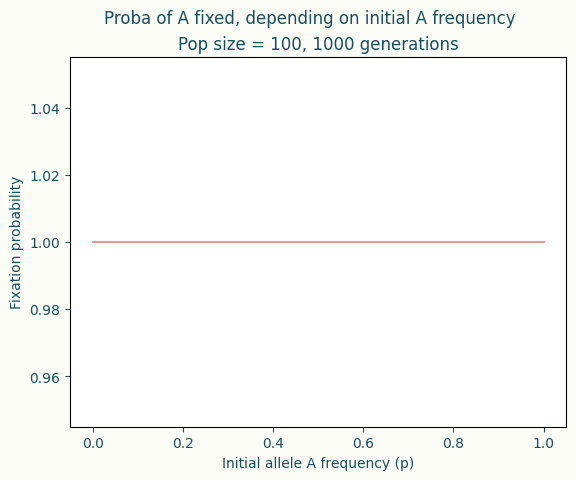

In [359]:
all_proba_A_fixed = []
p_values = np.round(np.linspace(0, 1, 11), 1)
model.update_t(1000)
for p in tqdm(p_values):
    model.update_p(p)
    _, freq_A_fixed, _ = model.estimate_simulation_parameters()
    all_proba_A_fixed.append(freq_A_fixed)
    
plt.plot(p_values, all_proba_A_fixed, label="Proba A fixed", color="#ea9999")
plt.xlabel("Initial allele A frequency (p)")
plt.ylabel("Fixation probability")
plt.suptitle("Proba of A fixed, depending on initial A frequency");
plt.title(f"Pop size = {model.N}, {model.t} generations");

While running simulation on 1000 generations instead 100, we indeed see that the fixation probability is 1.

### c) Expected fixation time in dependence of N

To estimate fixation time, several simulations are run for 20 values of N : 50, 100, 150, ..., 950, 1000. Then, the fixation time is estimated with the average fixation time over all simulations run for the given value of N.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:43<00:00, 14.17s/it]


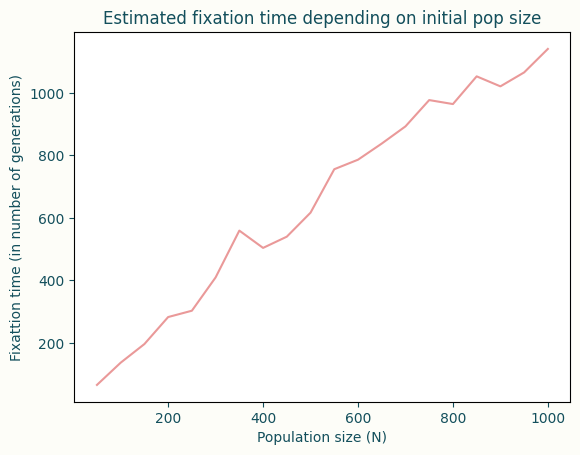

In [411]:
model = GeneticDriftModel(N=100, t=2500, p=0.5, nb_simulations=100)
all_time_A_fixed = []
N_values = np.round(np.linspace(50, 1000, 20), 1).astype(int)
for N in tqdm(N_values):
    model.update_N(N)
    _, _, avg_time_A_fixed = model.estimate_simulation_parameters()
    all_time_A_fixed.append(avg_time_A_fixed)
    
plt.plot(N_values, all_time_A_fixed, label="Time A fixed", color="#ea9999")
plt.xlabel("Population size (N)")
plt.ylabel("Fixattion time (in number of generations)")
plt.title("Estimated fixation time depending on initial pop size");

### Comparison with theorical results


## 2) Coalescent model

In [453]:
import numpy as np
import copy

def generate_combinations(arr, num_combinations, comb_size):
    n = len(arr)
    combinations = []


    for _ in range(num_combinations):
        # Generate 5 random indices without replacement
        random_indices = np.random.choice(n, size=comb_size, replace=False)
        combination = arr[random_indices].tolist()
        if len(combination) == comb_size:
            combinations.append(combination)

    return combinations


class CoalescentModel:
    """
    Coalescent model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    t : int
        Number of generations to simulate
    sample_size : int
        Size of sample to mesure first coalescent event
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a coalescent model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, t, sample_size, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.nb_simulations = nb_simulations
        self.sample_size = sample_size
        self.all_alleles_id_by_descent = False


    def estimate_nb_gen_to_fce(self, parents_matrix):
        """ fce is first coalescent event
        The number of generations to reach fce is computed for every sample 
        given the sample size, then the true number of generations to reach fce
        is estimated with empirical mean.
        A sample of size n is composed of n different individual indexes.
        """

        all_nb_gen_fce_reached = []
        # Trying all combinations is impossible, thus we'll only test 1000 combinations
        samples = generate_combinations(np.arange(self.N), 1000, self.sample_size)

        
        for sample in samples:
            fce_reached = False
            generation = 0
            indiv_idx = copy.deepcopy(sample)
            while not fce_reached:
                generation += 1
                parents_idx = np.unique(parents_matrix[-generation][indiv_idx])
                indiv_idx = parents_idx
                # If self.sample_size - 1 is replaced by 1, this loop will run
                # until MRCA is found
                fce_reached = (np.shape(parents_idx)[0] < self.sample_size)

            all_nb_gen_fce_reached.append(generation)

        estimated_nb_gen_fce_reached = np.mean(all_nb_gen_fce_reached)
        return estimated_nb_gen_fce_reached


    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals.
        Estimate the coalescence time

        Returns
        -------
        nb_gen_to_fce : int
            The nb of generations to first coalescent event for the given sample_size
            Estimated with empirical over all samples of size sample_size in the population
        """
        # Initialize population at time t=0
        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        alleles_id = np.arange(self.N)

        # parents_matrix(t, i) = j means that in generation t+1, allele nb i has as parent
        # allele nb j of generation t
        parents_matrix = np.random.randint(self.N, size=(self.t, self.N))
        
        for generation in range(self.t):

            # Retrieve parents
            parents = parents_matrix[generation]

            # Generate gen t + 1
            alleles_id = alleles_id[parents]

            # If all alleles id are the same, all alleles are identical by descent
            if np.shape(np.unique(alleles_id))[0] == 1:
                break

        nb_gen_to_fce = self.estimate_nb_gen_to_fce(parents_matrix[: generation + 1])

        return nb_gen_to_fce


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        nb_gen_to_fce : float
            Estimated number of generation to first coalescent event
        """

        all_nb_gen_to_fce = []
        for simulation in range(self.nb_simulations):
            nb_gen_to_fce = self.simulation()
            all_nb_gen_to_fce.append(nb_gen_to_fce)

            # Compte average allele nb gen to fce at each generation
            avg_nb_gen_to_fce = np.mean(all_nb_gen_to_fce)

        return avg_nb_gen_to_fce
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_t(self, new_t):
        self.t = new_t

    def update_sample_size(self, new_sample_size):
        self.sample_size = new_sample_size

In [469]:
all_nb_gen_to_fce = []
for n in range(50, 75, 1):
    model_co = CoalescentModel(N=100, t=1000, p=0.5, sample_size=n, nb_simulations=30)
    etn = model_co.estimate_simulation_parameters()
    all_nb_gen_to_fce.append(etn)

100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


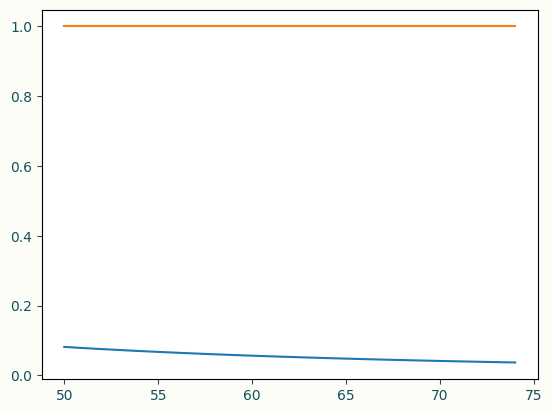

In [471]:
theoretical = np.arange(50, 75, 1)
theoretical = 200/(theoretical * (theoretical -1))
x = range(50, 75, 1)
plt.plot(x, theoretical)
plt.plot(x, all_nb_gen_to_fce)

In [ ]:
np.random.randint(, size=(t, N))

In [468]:
N = 10
t = 1000

alleles_id = np.arange(N)
all_alleles_id = [alleles_id]

# parents_matrix(t, i) = j means that in generation t+1, allele nb i has as parent
# allele nb j of generation t
parents_matrix = np.random.randint(N, size=(t, N))

all_alleles_id_by_descent = False
for generation in range(t):

    # Only generate generation t+1 if alleles are not all identical by descent
    if not all_alleles_id_by_descent:
        # Retrieve parents
        parents = parents_matrix[generation]
        alleles_id = alleles_id[parents]
        all_alleles_id.append(alleles_id)
        if np.shape(np.unique(alleles_id))[0] == 1:
            all_alleles_id_by_descent = True
            break
print(generation)
print(np.shape(parents_matrix[: 19]))

20
(19, 10)


In [55]:
print(f"generation 0: {ids[0]}")
sample = [0, 1]  #sample to look at in last generation
for i, (parent, aids) in enumerate(zip(p, ids[1:])):
    print(f"parent of generation {i+1}: {parent}")
    print(f"generation {i+1}: {aids}")

generation 0: [0 1 2 3 4 5]
parent of generation 1: [4 3 3 1 5 2]
generation 1: [4 3 3 1 5 2]
parent of generation 2: [2 1 0 2 0 4]
generation 2: [3 3 4 3 4 5]
parent of generation 3: [2 3 3 3 2 4]
generation 3: [4 3 3 3 4 4]
parent of generation 4: [5 5 5 0 3 2]
generation 4: [4 4 4 4 3 3]
parent of generation 5: [1 2 3 3 5 5]
generation 5: [4 4 4 4 3 3]
parent of generation 6: [2 4 3 1 3 1]
generation 6: [4 3 4 4 4 4]
parent of generation 7: [2 3 2 0 2 0]
generation 7: [4 4 4 4 4 4]


## 3) Mutations in the infinite-allele model

To simulate mutations, we encode all allele A by 1, all allele B by -1. Everytime an allele mutates, the allele will be encoded with 0. Since every mutation creates a unique allele, and the goal is only to compute the fixation index, only alleles with no mutation can be identical.

In [361]:
class MutationModel:
    """
    Mutation model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    u : proba
        Mutation rate
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a mutation model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, u, t, nb_simulations):
        self.N = N
        self.p = p
        self.u = u
        self.t = t
        self.nb_simulations = nb_simulations
        self.theta = 2 * self.u * self.N
        self.f_eq = 1 / (1 + self.theta)
        # All possible pairs of alleles. Will be used for Fixation Index
        self.idx_couples = np.array(list(combinations(range(self.N), 2)))


    def get_fixation_index(self, population):
        """Estimate the fixation index on a given population
        """

        # 1 - Retrieve all possible pair of alleles
        allele_pairs = population[self.idx_couples]

        # 2 - Get identical alleles
        identical_alleles = allele_pairs[allele_pairs[:, 0] == allele_pairs[:, 1]]

        # 3 - Compute fixation index
        fixation_index = len(identical_alleles) / len(self.idx_couples)

        return fixation_index
    

    def initialize_population(self):
        """Initialize population at time t = 0
        """

        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N)
        nb_B = self.N - nb_A
        # Create population of size N, with alleles A and B on random individuals
        population = np.concatenate((np.full(nb_A, "A"), np.full(nb_B, "B")), dtype=object)
        return population

    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals,
        with mutation

        Parameters
        ----------
        N : int
            Population size
        p : proba
            Inital allele A frequency. 
        u : proba
            Probability that an allele mutates in each generation
        t : int
            Number of generations to simulate

        Returns
        -------
        population_evolution : list of lists
            Each sublist describes the population at time t
        fixation indexes : list of proba
            Contains computed fixation index at each generation
        """
        population = self.initialize_population()

        # mutation_matrix contains the realisations of a random variable following N([0, 1])
        # Thus, allele N in generation t mutates if mutation_matrix(t, n) < u
        mutation_matrix = np.random.rand(self.t, self.N)

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        parents_matrix = np.random.randint(self.N, size=(self.t, self.N))

        # Store populations and fixation indexes for all generations
        population_evolution = [population]
        fixation_indexes = [self.get_fixation_index(population)]

        # Each mutation will be encoded by a unique id
        get_mutation_id = np.vectorize(lambda allele_idx: f"M_{generation}_{allele_idx}")

        for generation in range(self.t):
            # Retrieve genes that mutates
            mutated_alleles_index = np.where(mutation_matrix[generation] < self.u)

            if np.size(mutated_alleles_index) > 0:
                population[mutated_alleles_index] = get_mutation_id(mutated_alleles_index)

            # Retrieve parents of pop t+1
            parents = parents_matrix[generation]
            
            # Generate population t+1 with selected parents
            population = population[parents]
            population_evolution.append(population)

            # Compute fixation index for gen t+1
            fixation_index = self.get_fixation_index(population)
            fixation_indexes.append(fixation_index)
        
        return population_evolution, fixation_indexes


    def estimate_fixation_index(self):
        """
        Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations

        Returns
        -------
        avg_fixation_indexes : list of proba
            Contains computed fixation index at each generation. 
            Fixation indexes are estimated over all simulations.
        """
        all_fixation_indexes = []
        for simulation in tqdm(range(self.nb_simulations)):
            _, fixation_indexes = self.simulation()
            all_fixation_indexes.append(fixation_indexes)

        avg_fixation_indexes = np.mean(all_fixation_indexes, axis=0)
        return avg_fixation_indexes


    def theorical_fixation_index(self):
        """
        Compute fixation index from theorical results

        Returns
        -------
        fixation_indexes : list of proba
            Contains computed fixation index at each generation. 
        """
    
        population = self.initialize_population()

        fixation_index = self.get_fixation_index(population)
        fixation_indexes = [fixation_index]
        for generation in range(self.t):
            fixation_index = (1/self.N)*(1 - self.u)**2 + fixation_index*(1 - 1/self.N)*(1 - self.u)**2
            fixation_indexes.append(fixation_index)
        return fixation_indexes

    def update_u(self, new_u):
        self.u = new_u
        self.theta = 2 * self.N * self.u
        self.f_eq = 1 / (1 + self.theta)

    def update_N(self, new_N):
        self.N = new_N
        self.idx_couples = np.array(list(combinations(range(self.N), 2)))
        self.theta = 2 * self.N * self.u
        self.f_eq = 1 / (1 + self.theta)


### Comparison with theorical results

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:05<00:00,  5.90it/s]


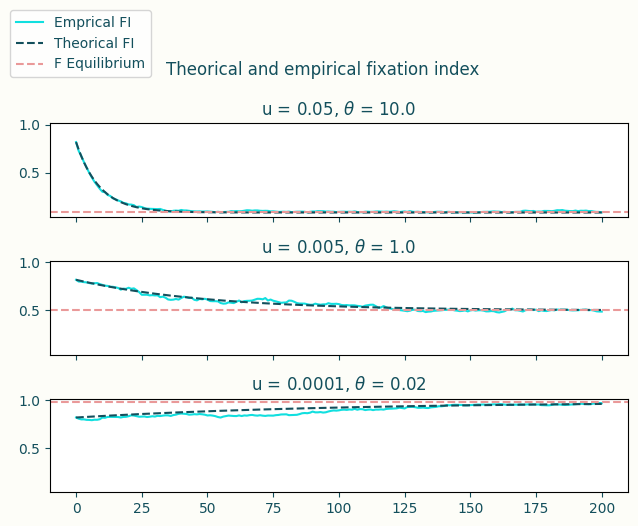

In [363]:
N = 100 # Population size
p = 0.9 # Initial allele A frequency
u = 0.1 # mutation rate
t = 200 # Number of generations
model_mutation = MutationModel(N, p, u, t, 30)

f, axes = plt.subplots(3, 1, sharey=True, sharex=True)
(sp1, sp2, sp3) = axes
N_values = [100, 100, 100]
u_values = [0.05, 0.005, 0.0001]
for N, u, sp in zip(N_values, u_values, [sp1, sp2, sp3]):
    model_mutation.update_N(N)
    model_mutation.update_u(u)
    avg_fixation_indexes = model_mutation.estimate_fixation_index()
    true_fixation_indexes = model_mutation.theorical_fixation_index()
    sp.plot(avg_fixation_indexes, color="#11dfdf")
    sp.plot(true_fixation_indexes, color="#134f5c", linestyle="--")
    sp.axhline(y=model_mutation.f_eq, color="#ea9999", linestyle="--", label=f"y = {model_mutation.f_eq}")
    sp.set_title(rf"u = {model_mutation.u}, $\theta$ = {model_mutation.theta}")
f.legend(["Emprical FI", "Theorical FI", "F Equilibrium"], loc='upper left', bbox_to_anchor=(0, 1.1), ncol=1)
f.suptitle("Theorical and empirical fixation index")
f.tight_layout()

## 4) Selection

In [364]:
class FitnessModel:
    """
    Fitness model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    w : float
        1 + w is fitness of B, while 1 is fitness of A
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, w, t, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.w = w
        self.nb_simulations = nb_simulations

    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of diploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p

        # allele frequencies  change at each generation
        current_N = 2 * self.N
        current_A_freq = self.p
        current_B_freq = 1 - self.p

        # Store values of allele frequencies at each generation
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]

        for generation in range(self.t):
            # Generate probability for all allele in the population
            proba_parents_A, proba_parents_B = np.random.rand(2, current_N)

            # Proba of chosing B is proportionnal to fitness
            parents_A = np.sum(proba_parents_A <= current_A_freq)
            parents_B = np.sum(proba_parents_B <= current_B_freq * (1 + self.w))

            current_N = parents_A + parents_B
            current_A_freq = parents_A / current_N
            current_B_freq = parents_B / current_N

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)
        
        return A_freq, B_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        """

        all_A_freq = []
        all_B_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq = self.simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)

        return (avg_A_freq, avg_B_freq)
    
    def theorical_frequencies(self):
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N * 2)
        nb_B = 2 * self.N - nb_A

        all_nb_B = (np.full(self.t, (1 + self.w)) ** range(self.t)) * nb_B
        all_nb_A = np.full(self.t, nb_A)
        all_N = all_nb_A + all_nb_B

        true_A_freq = all_nb_B / all_N
        true_B_freq = all_nb_B / all_N

        return (true_A_freq, true_B_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_w(self, new_w):
        self.w = new_w

6it [00:53,  8.94s/it]


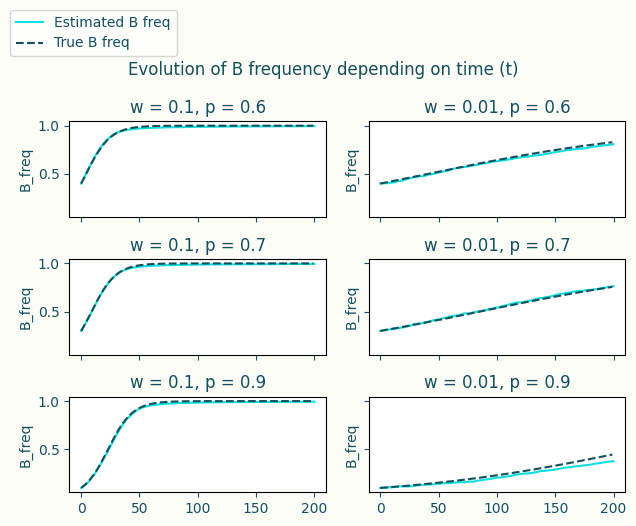

In [366]:
N = 500 # Population size
p = 0.5 # Initial allele A frequency
w = 0.1 # fitness
t = 200 # Number of generations
model_fitness = FitnessModel(N, p, w, t, 30)

f, axes = plt.subplots(3, 2, sharey=True, sharex=True)
(sp1, sp2), (sp3, sp4), (sp5, sp6) = axes[0], axes[1], axes[2]
p_values = [0.6, 0.6, 0.7, 0.7, 0.9, 0.9]
w_values = [0.1, 0.01, 0.1, 0.01, 0.1, 0.01]
for p, w, sp in tqdm(zip(p_values, w_values, [sp1, sp2, sp3, sp4, sp5, sp6])):
    model_fitness.update_p(p)
    model_fitness.update_w(w)
    (avg_A_freq, avg_B_freq) = model_fitness.estimate_simulation_parameters()
    (true_A_freq, true_B_freq) = model_fitness.theorical_frequencies()
    sp.plot(avg_B_freq, color="#11dfdf")
    sp.plot(true_B_freq, color="#134f5c", linestyle="--")
    sp.set_ylabel("B_freq")
    sp.set_title(rf"w = {model_fitness.w}, p = {model_fitness.p}")
f.legend(["Estimated B freq", "True B freq"], loc='upper left', bbox_to_anchor=(0, 1.1))
f.suptitle("Evolution of B frequency depending on time (t)")
f.tight_layout()

## Question 5)

In [367]:
class ClonalInterferenceModel:
    """
    Clonal Interference model

    ...

    Attributes
    ----------
    N : int
        Population size
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, t, nb_simulations):
        self.N = N
        self.t = t
        self.pA = 0.79
        self.pB = 0.2
        self.pC = 0.01
        self.wA = 0
        self.wB = 0.05
        self.wC = 0.1
        self.nb_simulations = nb_simulations

    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of diploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        C_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p

        # allele frequencies  change at each generation
        current_N = 3 * self.N
        current_A_freq = self.pA
        current_B_freq = self.pB
        current_C_freq = self.pC

        # Store values of allele frequencies at each generation
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]
        C_freq = [current_C_freq]

        for generation in range(self.t):
            # Generate probability for all allele in the population
            proba_parents_A, proba_parents_B, proba_parents_C = np.random.rand(3, current_N)

            parents_A = np.sum(proba_parents_A <= current_A_freq)
            parents_B = np.sum(proba_parents_B <= current_B_freq * (1 + self.wB))
            parents_C = np.sum(proba_parents_C <= current_C_freq * (1 + self.wC))

            current_N = parents_A + parents_B + parents_C
            current_A_freq = parents_A / current_N
            current_B_freq = parents_B / current_N
            current_C_freq = parents_C / current_N

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)
            C_freq.append(current_C_freq)
        
        return A_freq, B_freq, C_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        avg_N : int
            For each generation, the average population size
        """

        all_A_freq = []
        all_B_freq = []
        all_C_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq, C_freq = self.simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)
            all_C_freq.append(C_freq)

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)
        avg_C_freq = np.mean(all_C_freq, axis=0)

        return (avg_A_freq, avg_B_freq, avg_C_freq)
    
    def theorical_frequencies(self):
        # Initialize population at time t=0
        # N diploid individual, with allele A freq = pA, allele B freq = pB, allele C freq = pC
        nb_A = round(self.pA * self.N * 3)
        nb_B = round(self.pB * self.N * 3)
        nb_C = 3 * self.N - (nb_A + nb_B)

        all_nb_A = (np.full(self.t, (1 + self.wA)) ** range(self.t)) * nb_A
        all_nb_B = (np.full(self.t, (1 + self.wB)) ** range(self.t)) * nb_B
        all_nb_C = (np.full(self.t, (1 + self.wC)) ** range(self.t)) * nb_C

        all_N = all_nb_A + all_nb_B + all_nb_C
        true_A_freq = all_nb_A / all_N
        true_B_freq = all_nb_B / all_N
        true_C_freq = all_nb_C / all_N

        return (true_A_freq, true_B_freq, true_C_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_w(self, new_w):
        self.w = new_w

### Comparison with theorical results

0it [00:00, ?it/s]

4it [03:42, 55.70s/it]


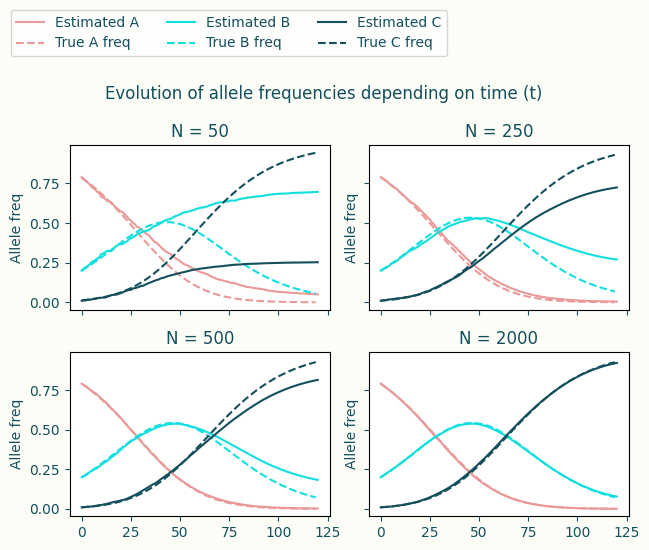

In [369]:
N = 100 # Population size
t = 120 # Number of generations
model_clonal = ClonalInterferenceModel(N, t, nb_simulations=30)

f, axes = plt.subplots(2, 2, sharey=True, sharex=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
N_values = [50, 250, 500, 2000]
for N, sp in tqdm(zip(N_values, [sp1, sp2, sp3, sp4])):
    model_clonal.update_N(N)
    (avg_A_freq, avg_B_freq, avg_C_freq) = model_clonal.estimate_simulation_parameters()
    (true_A_freq, true_B_freq, true_C_freq) = model_clonal.theorical_frequencies()
    sp.plot(avg_A_freq, color="#ea9999")
    sp.plot(true_A_freq, color="#ea9999", linestyle="--")
    sp.plot(avg_B_freq, color="#11dfdf")
    sp.plot(true_B_freq, color="#11dfdf", linestyle="--")
    sp.plot(avg_C_freq, color="#134f5c")
    sp.plot(true_C_freq, color="#134f5c", linestyle="--")
    sp.set_ylabel("Allele freq")
    sp.set_title(rf"N = {model_clonal.N}")
f.legend(["Estimated A", "True A freq", "Estimated B", "True B freq", "Estimated C", "True C freq"],
         loc='upper left', bbox_to_anchor=(0, 1.15), ncols=3)
f.suptitle("Evolution of allele frequencies depending on time (t)")
f.tight_layout()

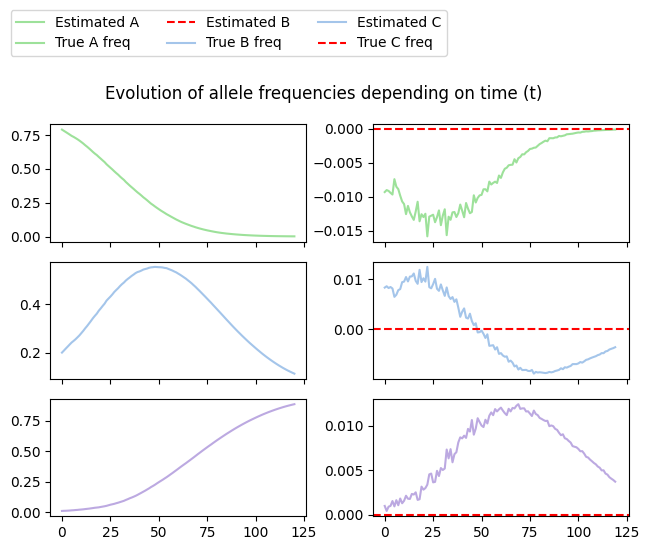

In [16]:
f, axes = plt.subplots(3, 2, sharex=True)
(sp1, sp2), (sp3, sp4), (sp5, sp6) = axes[0], axes[1], axes[2]
sp1.plot(avg_A_freq, color="#9de19a")
delta_A_freq = [avg_A_freq[i] - avg_A_freq[i-1] for i in range(1, len(avg_A_freq))]
sp2.plot(delta_A_freq, color="#9de19a")
sp2.axhline(y=0, color="red", linestyle="--")

sp3.plot(avg_B_freq, color="#a4c5ea")
delta_B_freq = [avg_B_freq[i] - avg_B_freq[i-1] for i in range(1, len(avg_B_freq))]
sp4.plot(delta_B_freq, color="#a4c5ea")
sp4.axhline(y=0, color="red", linestyle="--")

sp5.plot(avg_C_freq, color="#bca9e1")
delta_C_freq = [avg_C_freq[i] - avg_C_freq[i-1] for i in range(1, len(avg_C_freq))]
sp6.plot(delta_C_freq, color="#bca9e1")
sp6.axhline(y=0, color="red", linestyle="--")

f.legend(["Estimated A", "True A freq", "Estimated B", "True B freq", "Estimated C", "True C freq"],
        loc='upper left', bbox_to_anchor=(0, 1.15), ncols=3)
f.suptitle("Evolution of allele frequencies depending on time (t)")
f.tight_layout()

## 6) Population Structure

In [397]:
def estimate_fixation_time(model, nb_sub_populations):
    """Simulate a population divided in nb_sub_population subpopulations and estimate fixation time
    """
    all_time_A_fixed = []

    # Do several simulations to estimate fixation time
    for simulation in range(model.nb_simulations):
        subpops_time_A_fixed = []

        # Generate each subpopulation
        for subpop in range(nb_sub_populations):
            is_fixed = False

            # Only keep fixed subpopulations
            while not is_fixed:
                A_freq_subpop = model.simulation()
                is_fixed = (1 in A_freq_subpop) or (0 in A_freq_subpop)

            # Look at first index where frequency equals 1 or 0
            subpop_time_A_fixed = A_freq_subpop.index(1) if 1 in A_freq_subpop else A_freq_subpop.index(0)
            subpops_time_A_fixed.append(subpop_time_A_fixed)

        # Allele A is fixed if it is fixed in all subpopulations
        # Thus, fixation time is equal to the time where the last subpopulation is fixed
        time_A_fixed = max(subpops_time_A_fixed)
        all_time_A_fixed.append(time_A_fixed)

    # Estimate global fixation time with empirical mean
    return np.mean(all_time_A_fixed)



a = []
nb_sub_populations = 10
model = GeneticDriftModel(N=subpopulation_size, t=500, p=0.75, nb_simulations=100)
N_values = np.round(np.linspace(50, 1000, 20), 1).astype(int)
for N in tqdm(N_values):
    subpopulation_size = round(N / nb_sub_populations)
    model.update_N(subpopulation_size)
    ft = estimate_fixation_time(model, nb_sub_populations)
    a.append(ft)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [16:27:16<00:00, 2961.82s/it]    


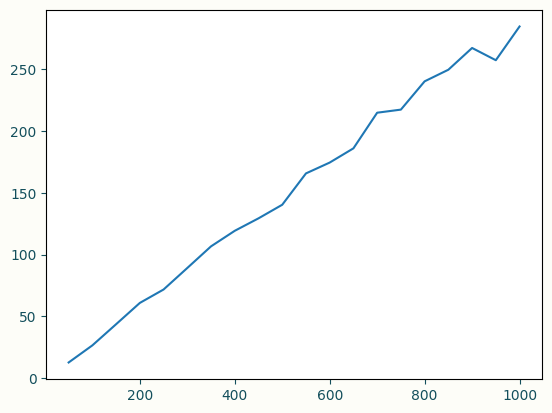

In [399]:
plt.plot(N_values, a)

## 7) Migration

In [407]:
import random
import copy

class PopulationModel:
    """
    Population Structure model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    t : int
        Number of generations to simulate
    m : proba
        percentage of migration
    nb_sub_pop : int
        Number of sub populations
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    simulation:
        Run a model simulation with given parameters

    estimate_simulation_parameters:
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, t, m, nb_sub_pop, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.m = m
        self.nb_simulations = nb_simulations
        self.nb_sub_pop = nb_sub_pop
        self.subpop_size, _ = divmod(self.N, self.nb_sub_pop)
        if self.m:
            self.migration_size = round(self.m * (self.N / self.nb_sub_pop))

    def initialize_population(self):
        subpop_size, remainder = divmod(self.N, self.nb_sub_pop)

        # All subpopulations have to be of same size for simulation purposes
        if remainder != 0:
            print(f"Pop size changed from {self.N} to {self.N - remainder} for migration simulation purposes")
            self.update_N(self.N - remainder)

        nb_A_subpop = round(self.p * subpop_size)
        nb_B_subpop = subpop_size - nb_A_subpop
        populations = [
            np.concatenate((np.full(nb_A_subpop, 'A'), np.full(nb_B_subpop, 'B')))
            for _ in range(self.nb_sub_pop)
        ]
        for subpop in populations:
            np.random.shuffle(subpop)

        # sanity check
        assert sum([len(subpop) for subpop in populations]) == self.N
        return populations
    

    def get_subpops_migration_towards(self):
        """ Generate, for each subpopulation, the other subpopulation towards migration is done.
        Simulating the migration "towards" for all subpopulation implies that all migrations "from"
        are also simulated.

        A subpop cannot migrate towards itself

        Migration directions list has to be understood this way:
            - for i, j in enumerate(migration_towards): sub_pop i migrates towards sub_pop j
            / or sub_pop j receice migration from sub_pop i
        Thus, the list is of size nb_subpop, and contains integers in range(nb_subpop).

        Returns
        -------
        all_migration_towards : list of lists
            Contains the migration_towards list for each generation

        """

        all_migration_towards = []
        for generation in range(self.t):
            
            migration_towards = list(range(self.nb_sub_pop))

            # A population cannot migrate towards itself
            while True in [i == subpop for i, subpop in enumerate(migration_towards)]:
                random.shuffle(migration_towards)

            all_migration_towards.append(migration_towards)

        return all_migration_towards
        

    def simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        """
        # Initialize population at time t=0
        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        # Population divided in 10 sub-populations
        populations = self.initialize_population()

        # Initialize allele frequencies, that will evolve through generations
        current_A_freq = self.p

        # Store all values of allele frequencies
        A_freq = [current_A_freq]

        # Retrieve size of each subpopulation

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        # Thus, parents_matrix_list[s] is the parent matrix for subpopulation nb s
        parents_matrix_list = [np.random.randint(self.subpop_size, size=(self.t, self.subpop_size)) for _ in populations]

        if self.m:
            # Retrieve, for each generation and subpopulation, the subpopulation towards migratation is done
            all_migrations_towards = self.get_subpops_migration_towards()
            
            # Randomly chose alleles that will migrate
            # At each generation, the same alleles will migrate in all subpopulations
            # Thus, alleles_migrate[t, a] is the alleles index that migrates for generation t
            alleles_migrate = np.array([np.sort(np.random.choice(self.subpop_size, size=self.migration_size, replace=False)) for _ in range(self.t)])

        for generation in range(self.t):
            if self.m:
                populations_tmp = copy.deepcopy(populations)
                migrations_towards = all_migrations_towards[generation]
                alleles_migrate_index = alleles_migrate[generation]

                for i, subpop_tmp in enumerate(populations_tmp):
                    populations[migrations_towards[i]][alleles_migrate_index] = subpop_tmp[alleles_migrate_index]

            # Retrieve parents for each subpop
            all_parents = [parents_matrix[generation] for parents_matrix in parents_matrix_list]

            # Update subpops based on selected parents
            populations = [sub_population[parents] for sub_population, parents in zip(populations, all_parents)]

            # Count A in all subpops
            nb_A_subpops = [np.sum(sub_population=="A") for sub_population in populations]

            # Compute new A frequency
            current_A_freq = sum(nb_A_subpops) / self.N

            A_freq.append(current_A_freq)

        return A_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        avg_A_freq : list of proba
            For each generation, average allele A frequency between all simulations
        freq_A_fixed : proba
            Frequency of allele A being fixed
        avg_time_A_fixed : proba
            Average allele A fixation time (in number of generations)
        """
        
        all_A_freq = []
        for simulation in range(self.nb_simulations):
            A_freq = self.simulation()
            all_A_freq.append(A_freq)

        # 1. Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        
        # 2. Compute frequency of fixed simulations
        # Get all simulations where A is fixed (ie. a frequency equals 1 or 0)
        sims_fixed_A_freq = [A_freq for A_freq in all_A_freq if (1 in A_freq) or (0 in A_freq)]
        print(sims_fixed_A_freq)

        if not sims_fixed_A_freq:
            error_message = "No simulations got fixed. Consider increasing t, or changing p"
            raise RuntimeError(error_message)

        # Compute frequencies of fixed simulations
        freq_A_fixed = len(sims_fixed_A_freq) / self.nb_simulations

        # 3. Compute average fixation time
        # Look for first generation where allele frequency is 1 or 0 within all fixed simulations
        time_A_fixed = [A_freq.index(1) if 1 in A_freq else A_freq.index(0) for A_freq in sims_fixed_A_freq]
        avg_time_A_fixed = np.mean(time_A_fixed)

        return avg_A_freq, freq_A_fixed, avg_time_A_fixed

    
    def update_p(self, new_p):
        self.p = new_p
    
    
    def update_N(self, new_N):
        self.N = new_N
        self.subpop_size, _ = divmod(self.N, self.nb_sub_pop)
        if self.m:
            self.migration_size = round(self.m * (self.N / self.nb_sub_pop))

    def update_t(self, new_t):
        self.t = new_t

3it [00:00,  5.48it/s]


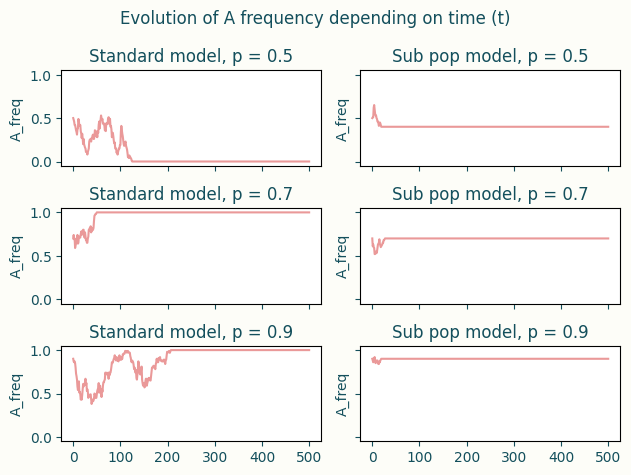

In [406]:

model_sub_pop = PopulationModel(N=100, t=500, p=0.8, m=None, nb_sub_pop=10, nb_simulations=30)
model = GeneticDriftModel(N=100, t=500, p=0.8, nb_simulations=30)

f, axes = plt.subplots(3, 2, sharey=True, sharex=True)
p_values = [0.5, 0.7, 0.9]

for p, ax in tqdm(zip(p_values, axes)):
    sp1, sp2 = ax
    model.update_p(p)
    model_sub_pop.update_p(p)
    A_freq = model.simulation()
    A_freq_sp = model_sub_pop.simulation()

    sp1.plot(A_freq, color="#ea9999")
    sp2.plot(A_freq_sp, color="#ea9999")
    sp1.set_ylabel("A_freq")
    sp2.set_ylabel("A_freq")
    sp1.set_title(f"Standard model, p = {model.p}")
    sp2.set_title(f"Sub pop model, p = {model_sub_pop.p}")
f.suptitle("Evolution of A frequency depending on time (t)")
f.tight_layout()


In [328]:

model = GeneticDriftModel(N=100, t=500, p=0.5, nb_simulations=100)
model_sub_pop = PopulationModel(N=100, t=500, p=0.5, m=0.3, nb_sub_pop=10, nb_simulations=30)

all_time_A_fixed = []
all_time_A_fixed_sp = []
N_values = np.round(np.linspace(50, 2500, 20), 1).astype(int)
for N in tqdm(N_values):
    model.update_N(N)
    model_sub_pop.update_N(N)
    _, _, avg_time_A_fixed = model.estimate_simulation_parameters()
    _, _, avg_time_A_fixed_sp = model_sub_pop.estimate_simulation_parameters()
    all_time_A_fixed.append(avg_time_A_fixed)
    all_time_A_fixed_sp.append(avg_time_A_fixed_sp)

  5%|▌         | 1/20 [00:11<03:42, 11.71s/it]

Pop size changed from 178 to 170 for migration simulation purposes


 10%|█         | 2/20 [00:24<03:42, 12.34s/it]

Pop size changed from 307 to 300 for migration simulation purposes


 15%|█▌        | 3/20 [00:37<03:37, 12.82s/it]

Pop size changed from 436 to 430 for migration simulation purposes


 20%|██        | 4/20 [00:51<03:33, 13.32s/it]

Pop size changed from 565 to 560 for migration simulation purposes


 25%|██▌       | 5/20 [01:06<03:24, 13.62s/it]

Pop size changed from 694 to 690 for migration simulation purposes


 30%|███       | 6/20 [01:21<03:17, 14.11s/it]

Pop size changed from 823 to 820 for migration simulation purposes


 35%|███▌      | 7/20 [01:36<03:07, 14.39s/it]

Pop size changed from 952 to 950 for migration simulation purposes


 40%|████      | 8/20 [01:52<03:01, 15.15s/it]

Pop size changed from 1081 to 1080 for migration simulation purposes


 50%|█████     | 10/20 [02:30<02:49, 16.91s/it]

Pop size changed from 1339 to 1330 for migration simulation purposes


 55%|█████▌    | 11/20 [02:50<02:42, 18.10s/it]

Pop size changed from 1468 to 1460 for migration simulation purposes


 60%|██████    | 12/20 [03:13<02:34, 19.37s/it]

Pop size changed from 1597 to 1590 for migration simulation purposes


 65%|██████▌   | 13/20 [03:36<02:23, 20.53s/it]

Pop size changed from 1726 to 1720 for migration simulation purposes


 70%|███████   | 14/20 [04:00<02:09, 21.63s/it]

Pop size changed from 1855 to 1850 for migration simulation purposes


 75%|███████▌  | 15/20 [04:26<01:54, 22.95s/it]

Pop size changed from 1984 to 1980 for migration simulation purposes


 80%|████████  | 16/20 [04:52<01:35, 23.99s/it]

Pop size changed from 2113 to 2110 for migration simulation purposes


 85%|████████▌ | 17/20 [05:22<01:17, 25.77s/it]

Pop size changed from 2242 to 2240 for migration simulation purposes


 90%|█████████ | 18/20 [05:55<00:55, 27.76s/it]

Pop size changed from 2371 to 2370 for migration simulation purposes


100%|██████████| 20/20 [07:00<00:00, 21.05s/it]


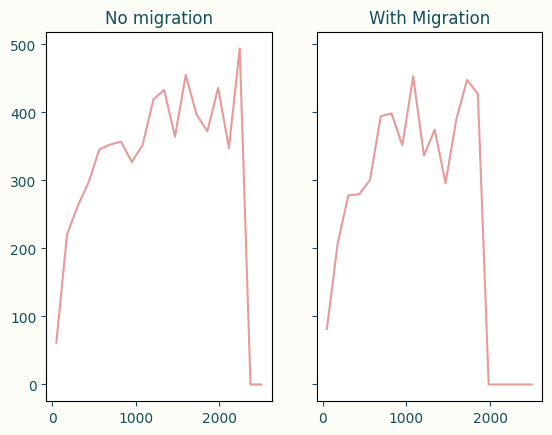

In [329]:
f, (sp1, sp2) = plt.subplots(1, 2, sharey=True)
sp1.plot(N_values, all_time_A_fixed, color="#ea9999")
sp1.set_title("No migration")

sp2.plot(N_values, all_time_A_fixed_sp, color="#ea9999")
sp2.set_title("With Migration");

In [333]:
l = [1, 2]
a = [v for v in l if v < 0]
l.append(a)
l

[1, 2, []]